## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.5, 0.25, 0.1]
redice_lr_patient = [5, 10]

In [21]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)

    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    exp_name_tag = "opt(%s)/fat(%s)/pat(%s)" % (str(optim)[18:21],str(reduce_factor),str(reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 8s 155us/step - loss: 1.4396 - accuracy: 0.4973 - val_loss: 1.5597 - val_accuracy: 0.4522
Epoch 11/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.4164 - accuracy: 0.5066 - val_loss: 1.5501 - val_accuracy: 0.4568
Epoch 12/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.3939 - accuracy: 0.5146 - val_loss: 1.5379 - val_accuracy: 0.4597
Epoch 13/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.3735 - accuracy: 0.5228 - val_loss: 1.5344 - val_accuracy: 0.4622
Epoch 14/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.3539 - accuracy: 0.5301 - val_loss: 1.5251 - val_accuracy: 0.4642
Epoch 15/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.3345 - accuracy: 0.5370 - val_loss: 1.5199 - val_accuracy: 0.4655
Epoch 16/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.3165 - accuracy: 0.5430 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 168us/step - loss: 2.3576 - accuracy: 0.2262 - val_loss: 2.1763 - val_accuracy: 0.1959
Epoch 2/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.8645 - accuracy: 0.3511 - val_loss: 2.0328 - val_accuracy: 0.2732
Epoch 3/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.7249 - accuracy: 0.3959 - val_loss: 1.9111 - val_accuracy: 0.3308
Epoch 4/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.6497 - accuracy: 0.4206 - val_loss: 1.8099 - val_accuracy: 0.3657
Epoch 5/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.5972 - accuracy: 0.4412 - val_loss: 1.7271 - val_accuracy: 0.3963
Epoch 6/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.5540 - accuracy: 0.4577 - val_loss: 1.6804 - val_accuracy: 0.4064
Epoch 7/25
50000/50000 [==============================] - 8s 1

50000/50000 [==============================] - 8s 156us/step - loss: 1.2377 - accuracy: 0.5708 - val_loss: 1.5028 - val_accuracy: 0.4737
Epoch 21/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.2222 - accuracy: 0.5790 - val_loss: 1.4980 - val_accuracy: 0.4736
Epoch 22/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.2063 - accuracy: 0.5859 - val_loss: 1.4896 - val_accuracy: 0.4798
Epoch 23/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.1911 - accuracy: 0.5888 - val_loss: 1.4979 - val_accuracy: 0.4752
Epoch 24/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.1757 - accuracy: 0.5966 - val_loss: 1.4836 - val_accuracy: 0.4818
Epoch 25/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.1622 - accuracy: 0.6010 - val_loss: 1.4918 - val_accuracy: 0.4783
Numbers of exp: 5, reduce_factor: 0.10, reduce_patient: 10
Model: "model_7"
__________________________________________

Epoch 5/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.2397 - accuracy: 0.5631 - val_loss: 1.8986 - val_accuracy: 0.3341
Epoch 6/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.1852 - accuracy: 0.5823 - val_loss: 1.6064 - val_accuracy: 0.4317
Epoch 7/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.1302 - accuracy: 0.6028 - val_loss: 1.9499 - val_accuracy: 0.3452
Epoch 8/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.0877 - accuracy: 0.6168 - val_loss: 1.7028 - val_accuracy: 0.4067
Epoch 9/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.0381 - accuracy: 0.6354 - val_loss: 1.8243 - val_accuracy: 0.3784
Epoch 10/25
50000/50000 [==============================] - 8s 169us/step - loss: 0.9923 - accuracy: 0.6499 - val_loss: 1.7097 - val_accuracy: 0.4221
Epoch 11/25
50000/50000 [==============================] - 8s 167us/step - loss: 0.9453 - accuracy: 0.6686 - va

50000/50000 [==============================] - 9s 171us/step - loss: 0.6194 - accuracy: 0.8114 - val_loss: 1.4587 - val_accuracy: 0.5070
Epoch 24/25
50000/50000 [==============================] - 9s 171us/step - loss: 0.5966 - accuracy: 0.8221 - val_loss: 1.4795 - val_accuracy: 0.5110
Epoch 25/25
50000/50000 [==============================] - 9s 173us/step - loss: 0.5826 - accuracy: 0.8285 - val_loss: 1.4883 - val_accuracy: 0.5068
Numbers of exp: 8, reduce_factor: 0.25, reduce_patient: 5
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
___________________________

50000/50000 [==============================] - 9s 174us/step - loss: 1.7765 - accuracy: 0.3866 - val_loss: 1.8101 - val_accuracy: 0.3602
Epoch 7/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.7468 - accuracy: 0.3966 - val_loss: 1.7763 - val_accuracy: 0.3734
Epoch 8/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.7211 - accuracy: 0.4043 - val_loss: 1.7546 - val_accuracy: 0.3812
Epoch 9/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.6993 - accuracy: 0.4102 - val_loss: 1.7409 - val_accuracy: 0.3853
Epoch 10/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.6804 - accuracy: 0.4178 - val_loss: 1.7310 - val_accuracy: 0.3888
Epoch 11/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.6620 - accuracy: 0.4232 - val_loss: 1.7266 - val_accuracy: 0.3902
Epoch 12/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.6467 - accuracy: 0.4265 - val_loss: 1.

Numbers of exp: 11, reduce_factor: 0.10, reduce_patient: 10
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_37 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_38 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________________________

50000/50000 [==============================] - 8s 167us/step - loss: 1.0142 - accuracy: 0.6473 - val_loss: 1.6030 - val_accuracy: 0.4415
Epoch 11/25
50000/50000 [==============================] - 8s 167us/step - loss: 0.9735 - accuracy: 0.6596 - val_loss: 1.5637 - val_accuracy: 0.4661
Epoch 12/25
50000/50000 [==============================] - 8s 167us/step - loss: 0.9374 - accuracy: 0.6751 - val_loss: 1.4901 - val_accuracy: 0.4853
Epoch 13/25
50000/50000 [==============================] - 8s 168us/step - loss: 0.9078 - accuracy: 0.6858 - val_loss: 1.6052 - val_accuracy: 0.4538
Epoch 14/25
50000/50000 [==============================] - 8s 165us/step - loss: 0.8785 - accuracy: 0.6971 - val_loss: 1.4315 - val_accuracy: 0.5051
Epoch 15/25
50000/50000 [==============================] - 8s 168us/step - loss: 0.8535 - accuracy: 0.7037 - val_loss: 1.4750 - val_accuracy: 0.4938
Epoch 16/25
50000/50000 [==============================] - 8s 167us/step - loss: 0.8259 - accuracy: 0.7143 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 204us/step - loss: 1.8950 - accuracy: 0.3510 - val_loss: 2.1289 - val_accuracy: 0.2254
Epoch 2/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.5873 - accuracy: 0.4467 - val_loss: 1.9312 - val_accuracy: 0.2923
Epoch 3/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.4776 - accuracy: 0.4843 - val_loss: 1.7718 - val_accuracy: 0.3914
Epoch 4/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.3975 - accuracy: 0.5141 - val_loss: 1.6525 - val_accuracy: 0.4330
Epoch 5/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.3404 - accuracy: 0.5332 - val_loss: 1.6396 - val_accuracy: 0.4157
Epoch 6/25
50000/50000 [==============================] - 8s 170us/step - loss: 1.2853 - accuracy: 0.5551 - val_loss: 1.5929 - val_accuracy: 0.4427
Epoch 7/25
50000/50000 [==============================] - 8s 

50000/50000 [==============================] - 8s 167us/step - loss: 1.5434 - accuracy: 0.4647 - val_loss: 1.6548 - val_accuracy: 0.4255
Epoch 20/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.5297 - accuracy: 0.4687 - val_loss: 1.6447 - val_accuracy: 0.4309
Epoch 21/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.5159 - accuracy: 0.4738 - val_loss: 1.6362 - val_accuracy: 0.4321
Epoch 22/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.5028 - accuracy: 0.4796 - val_loss: 1.6335 - val_accuracy: 0.4334
Epoch 23/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.4929 - accuracy: 0.4821 - val_loss: 1.6247 - val_accuracy: 0.4378
Epoch 24/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.4807 - accuracy: 0.4861 - val_loss: 1.6183 - val_accuracy: 0.4385
Epoch 25/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.4687 - accuracy: 0.4926 - val_loss:

50000/50000 [==============================] - 9s 173us/step - loss: 2.0829 - accuracy: 0.2982 - val_loss: 2.1546 - val_accuracy: 0.2180
Epoch 4/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.9801 - accuracy: 0.3240 - val_loss: 2.0587 - val_accuracy: 0.2615
Epoch 5/25
50000/50000 [==============================] - 9s 176us/step - loss: 1.9083 - accuracy: 0.3443 - val_loss: 1.9619 - val_accuracy: 0.2985
Epoch 6/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.8525 - accuracy: 0.3627 - val_loss: 1.8928 - val_accuracy: 0.3255
Epoch 7/25
50000/50000 [==============================] - 9s 170us/step - loss: 1.8072 - accuracy: 0.3746 - val_loss: 1.8444 - val_accuracy: 0.3475
Epoch 8/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.7694 - accuracy: 0.3863 - val_loss: 1.8143 - val_accuracy: 0.3565
Epoch 9/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.7369 - accuracy: 0.3963 - val_loss: 1.789

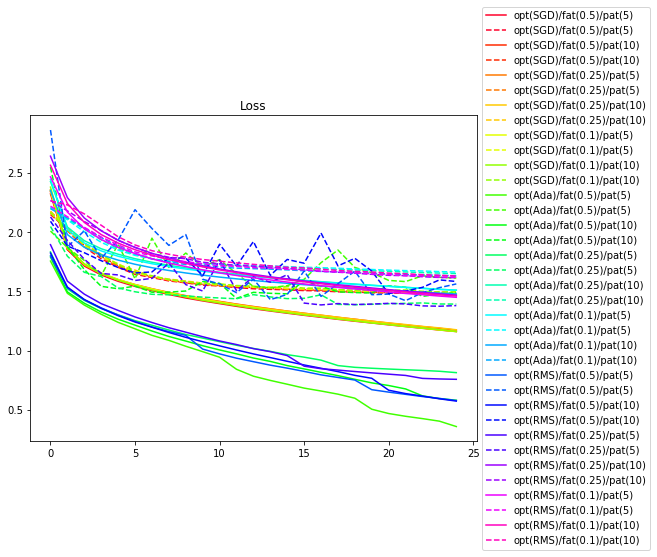

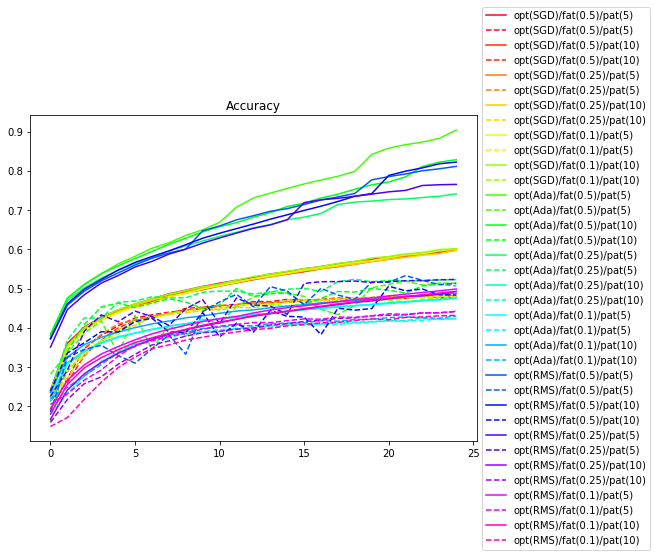

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()